Launching...
Generating terrain...
Shapefile read...
Plotting points...
41
Failure: Hammond, IN not in latitude range 41.5833688 Hammond, IN, USA
366
Failure: 1000 E. Midway Pl not in latitude range 41.7373602 1000 E 87th St, Chicago, IL 60619, USA


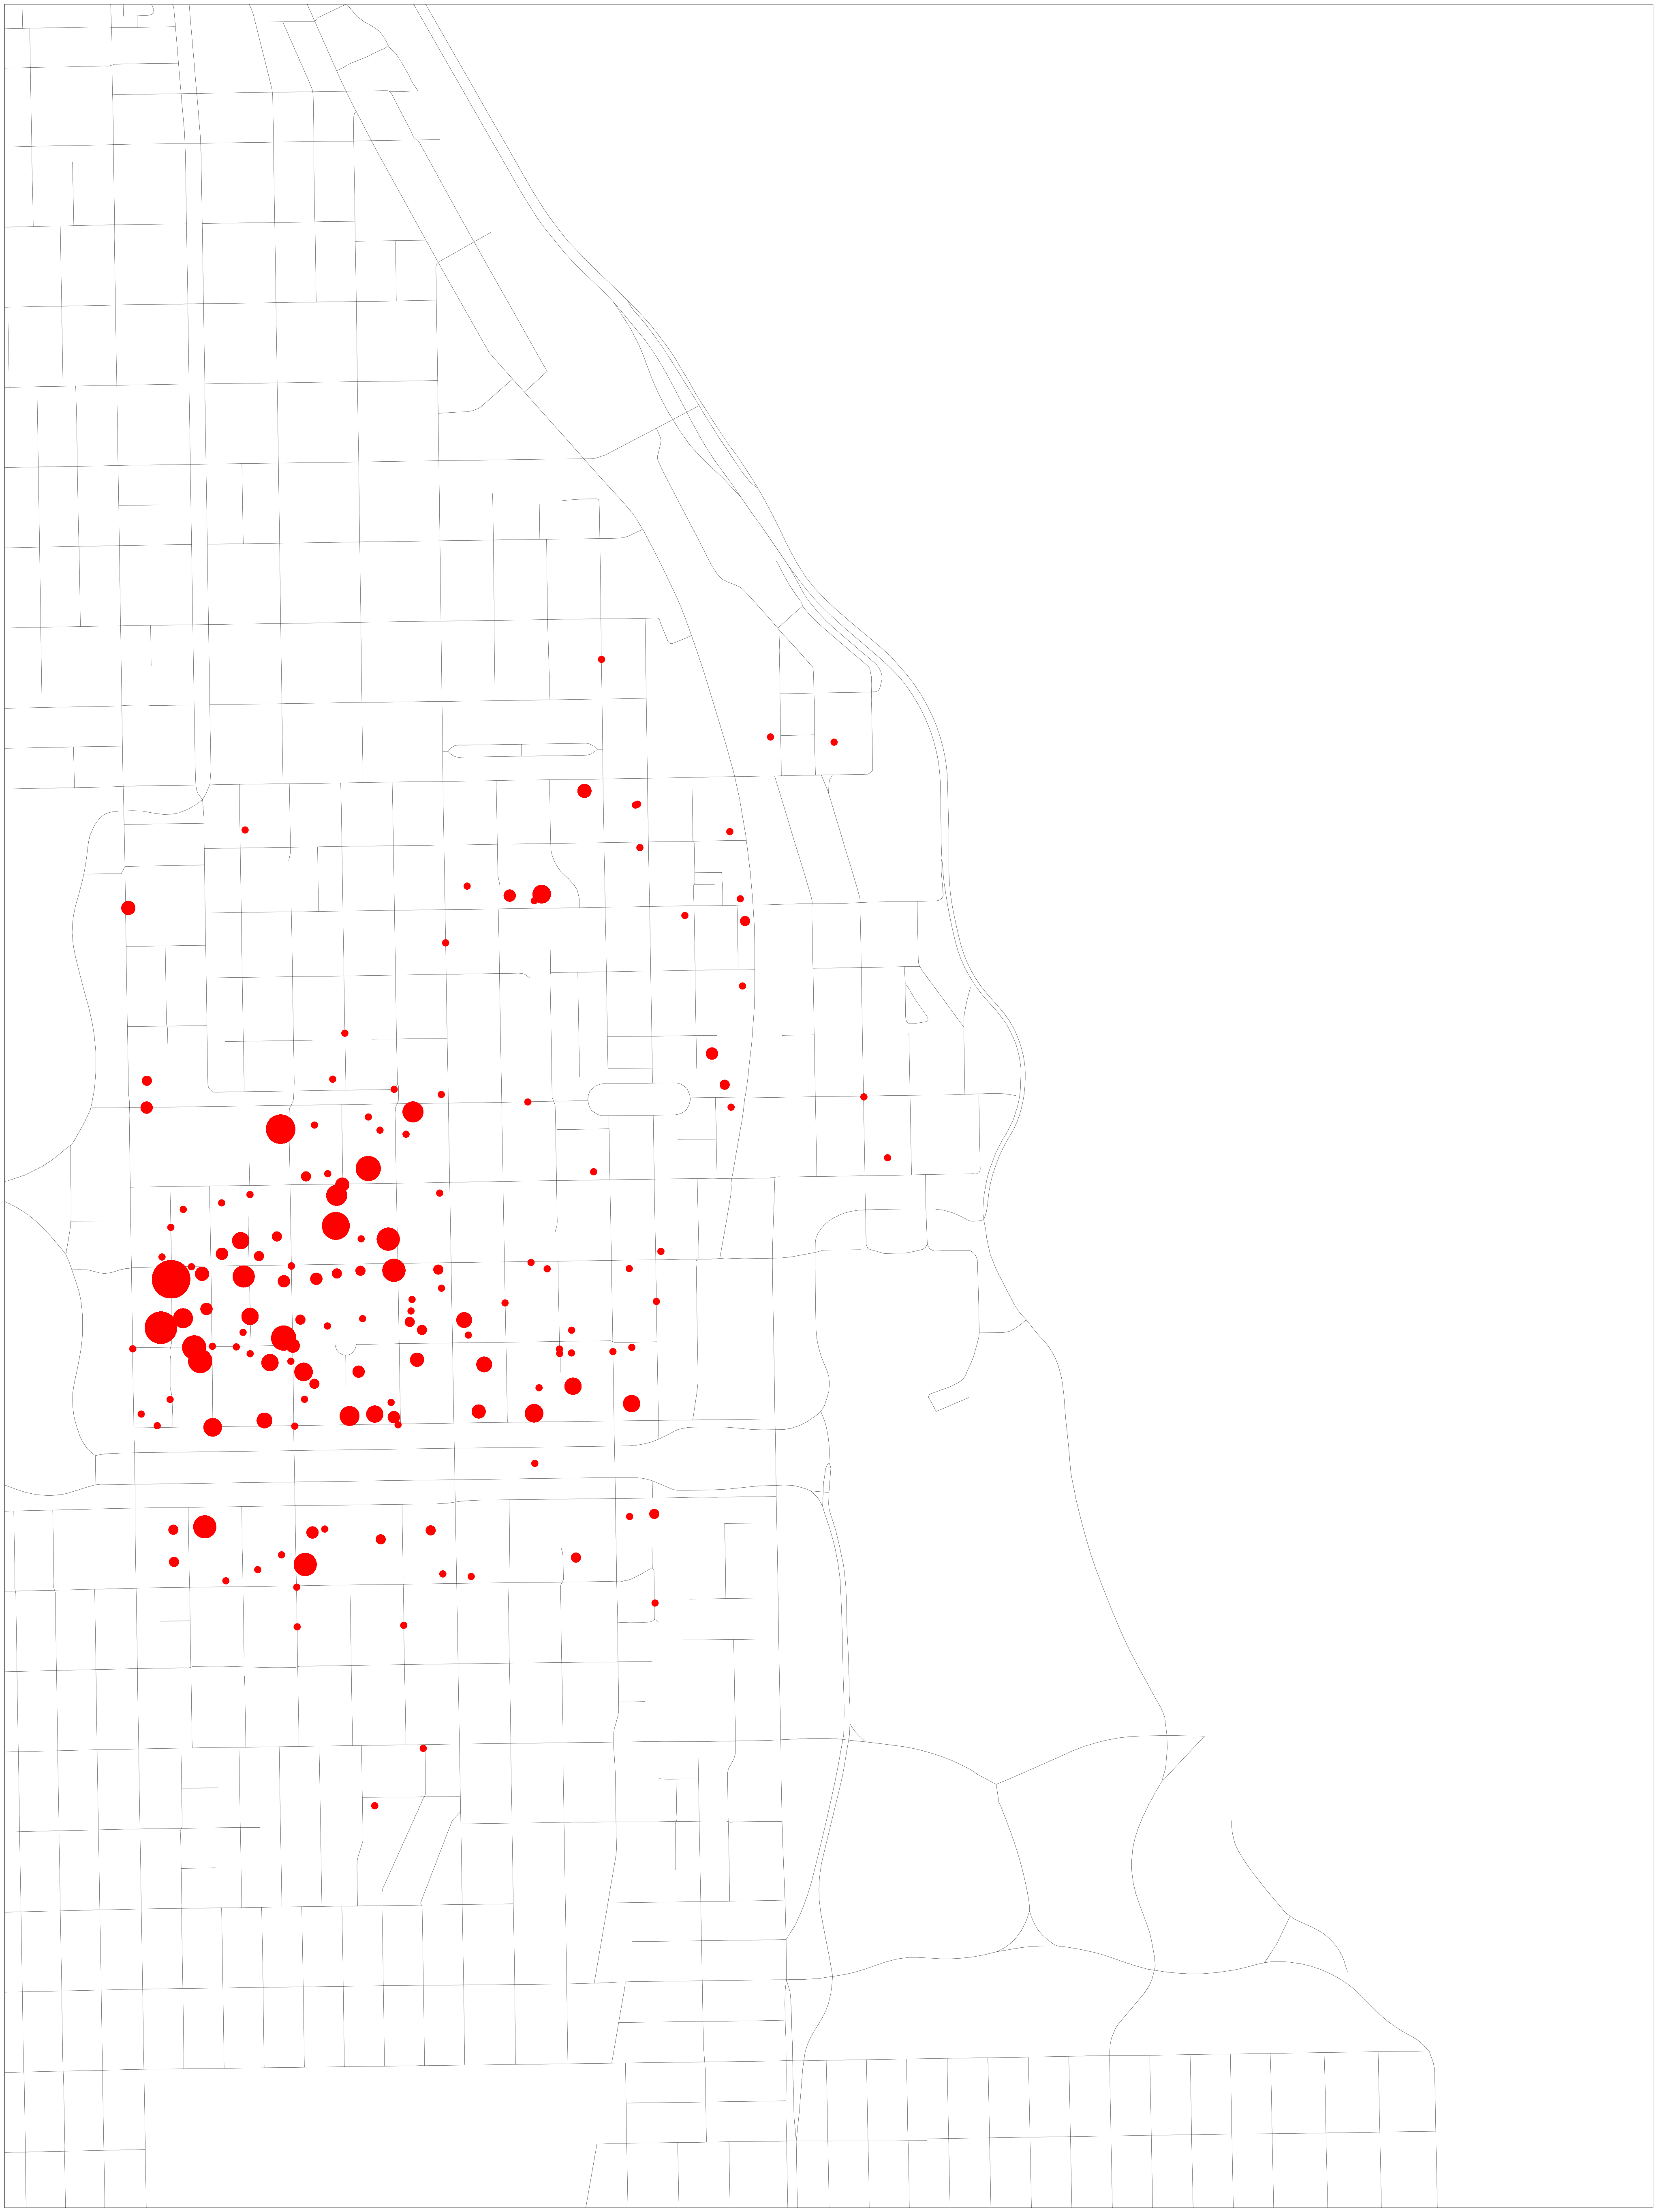

In [3]:
'''
Created on Jul 17, 2018

@author: arxli
'''

import matplotlib.pyplot as plt
import matplotlib.cm
import sqlite3
import time
import re

from geopy.geocoders import GoogleV3
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from collections import Counter

def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

def plotter(sqlfilter, clr, map, geo, cursor):
    id = 0
    ids = []
    lats = []
    longs = []

    for row in cursor.execute(sqlfilter):
        id += 1
        result = re.sub("[\(\[].*?[\)\]]", "", row[0])
        #result = "Maryland between 53rd & 54th"
        if 'between' in result.lower():
            test = result.lower().split('between')
            if 'and' in test[1]:
                woohoo = test[1].split(' and ')
            elif '&' in test[1]:
                woohoo = test[1].split('&')
            temp_lats = []
            temp_longs = []
            failure = False
            for woo in woohoo:
                if test[0].strip() == '':
                    address = woo.strip() + ', Chicago, IL'
                    address.replace('midway pl.', 'midway plaisance')
                    location = geo.geocode(address)
                    if location.latitude > 41.77 and location.latitude < 41.82:
                        if location.longitude > -87.67 and location.longitude < -87.56:
                            temp_lats.append(location.latitude)
                            temp_longs.append(location.longitude)
                        else:
                            print(id)
                            print(f'Failure: {address} not in longitude range {location.longitude}')
                            failure = True
                            break
                    else:
                        print(id)
                        print(f'Failure: {address} not in latitude range {location.latitude}')
                        failure = True
                        break
                else:
                    address = test[0].strip() + ' & ' + woo.strip() + ', Chicago, IL'
                    address.replace('midway pl.', 'midway plaisance')
                    location = geo.geocode(address)
                    if location.latitude > 41.77 and location.latitude < 41.82:
                        if location.longitude > -87.67 and location.longitude < -87.56:
                            temp_lats.append(location.latitude)
                            temp_longs.append(location.longitude)
                        else:
                            print(id)
                            print(f'Failure: {address} not in longitude range {location.longitude} {location.address}')
                            failure = True
                            break
                    else:
                        print(id)
                        print(f'Failure: {address} not in latitude range {location.latitude} {location.address}')
                        failure = True
                        break
            if failure == True:
                continue
            else:
                ids.append(id)
                lats.append(sum(temp_lats) / len(temp_lats))
                longs.append(sum(temp_longs) / len(temp_longs))
        elif findWholeWord('to')(result) != None:
            temp_lats = []
            temp_longs = []
            failure = False
            test = result.split(' to ')
            for question in test:
                address = question.strip() + ', Chicago, IL'
                address.replace('Midway Pl.', 'Midway Plaisance')
                location = geo.geocode(address)
                if location.latitude > 41.77 and location.latitude < 41.82:
                        if location.longitude > -87.67 and location.longitude < -87.56:
                            temp_lats.append(location.latitude)
                            temp_longs.append(location.longitude)
                        else:
                            print(id)
                            print(f'Failure: {address} not in longitude range {location.longitude} {location.address}')
                            failure = True
                            break
                else:
                    print(id)
                    print(f'Failure: {address} not in latitude range {location.latitude} {location.address}')
                    failure = True
                    break
            if failure == True:
                continue
            else:
                ids.append(id)
                lats.append(sum(temp_lats) / len(temp_lats))
                longs.append(sum(temp_longs) / len(temp_longs))
        else:
            result.replace('Midway Pl.', 'Midway Plaisance')
            location = geo.geocode(result + ', Chicago, IL')
            if location.latitude > 41.77 and location.latitude < 41.82:
                if location.longitude > -87.67 and location.longitude < -87.56:
                    ids.append(id)
                    lats.append(location.latitude)
                    longs.append(location.longitude)
                else:
                    print(id)
                    print(f'Failure: {result} not in longitude range {location.longitude} {location.address}')
            else:
                print(id)
                print(f'Failure: {result} not in latitude range {location.latitude} {location.address}')
            #print(result)
    #print(lats, longs)
    #print(ids)

    x,y = map(longs, lats)
    counter = Counter(zip(longs, lats))
    s = [(280*counter[(xx,yy)]) for xx,yy in zip(longs,lats)]
    map.scatter(x, y, latlon = False, color = clr, zorder = 10, s = s)
    return None

print('Launching...')

fig, ax = plt.subplots(figsize=(111,100))

print('Generating terrain...')

m = Basemap(projection='tmerc',
            llcrnrlat=41.77, urcrnrlat=41.82,
            llcrnrlon=-87.61, urcrnrlon=-87.56,
            lat_0=41.795, lon_0=-87.585,
            resolution='c')

#m  = Basemap(projection='ortho',lon_0=-87.575,lat_0=41.795,resolution='l',\
             #llcrnrx=2078.0,llcrnry=2776.7,
             #urcrnrx=-2078.0,urcrnry=-2776.7)

#m.drawlsmask(land_color='#f2f2f2',ocean_color='#46bcec',lakes=True)
#m.drawmapboundary(fill_color='#46bcec')
#m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')

m.readshapefile('C:\\Users\\arxli\\Desktop\\Street Center Lines\\test_file', 'roads', drawbounds = True, color = 'black')
print('Shapefile read...')

print('Plotting points...')

geolocator = GoogleV3(api_key='api_key')

conn = sqlite3.connect('C:\\Users\\arxli\\Desktop\\Ex_Files_Python_EssT\\Exercise Files\\Exercises\\test.db')
c = conn.cursor()

#plotter('SELECT c.Location FROM crimes c, incidents i WHERE (i.type = \'lost property\' or i.type = \'found property\') AND c.id = i.id;', 'r', m, geolocator, c)

plotter('SELECT c.Location FROM crimes c, incidents i WHERE i.type = \'theft\' AND c.id = i.id;', 'r', m, geolocator, c)

plt.show()